In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import soaplite
import soaputils as su
import genBasis
import ase
from ase.visualize import view
from ase.build import bulk
import numpy as np
from numpy.linalg import svd
import matplotlib as matplotlib
import matplotlib.pyplot as p
import numpy.linalg as nl
from scipy.optimize import fmin
import scipy.optimize as op
from scipy.spatial.distance import cdist
import time
%matplotlib notebook

In [2]:
rCut = 10.0
NradBas = 5
Lmax = 5
myAlphas, myBetas = genBasis.getBasisFunc(rCut, NradBas)

struct1 = ase.io.read(currentdir + "/glass_cube_CuZr.cfg")
mat1 = soaplite.get_periodic_soap_structure(struct1, myAlphas, myBetas, rCut, NradBas, Lmax)

struct2 = bulk('Cu', 'fcc', a=3.6, cubic=True)
struct2 = soaplite._get_supercell(struct2, rCut=2.0)
mat2 = soaplite.get_periodic_soap_structure(struct2, myAlphas, myBetas, rCut, NradBas, Lmax)

a0 = 4.0
c0 = 1*a0
struct3 = bulk('Au', 'fcc', a=a0, cubic=True)
struct3.set_cell(np.diag((a0,a0,c0)), scale_atoms=True)
struct3.set_chemical_symbols(('Au','Cu','Cu','Au'))
struct3 = soaplite._get_supercell(struct3, rCut=2.0)
mat3 = soaplite.get_periodic_soap_structure(struct3, myAlphas, myBetas, rCut, NradBas, Lmax)

#p.matshow(mat1)
#p.matshow(mat3)

In [3]:
rmin = 5
def cons(x):
    x = np.reshape(x,(-1,3))
    dist = cdist(x,x)
    np.fill_diagonal(dist,10.0)
    dist = np.reshape(dist,(-1,))
    amin = np.amin(dist)
    dist[:] = [x-amin-rmin for x in dist]
    return dist
#ineq_cons = {'type': 'ineq', 'fun': lambda x:  cons(x)}
ineq_cons = {'type': 'ineq', 'fun': lambda x:  cons(x)}

In [ ]:
# optimization with matrix-norm as function and unit cell as bounds
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
x0 = su.rand_pos(atoms_test).get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='L-BFGS-B',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, True),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

In [ ]:
# optimization with block-norm as function and unit cell as bounds
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
x0 = su.rand_pos(atoms_test).get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
periodic = False
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.norm_block, x0, method='L-BFGS-B',args=(atoms_test, 2, 0.3, myAlphas, myBetas, rCut, NradBas, Lmax, periodic),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=periodic)

In [ ]:
# unconstrained SLSQP optimization
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test)
atoms_test = su.lim_overlap(atoms_test, 3)
view(atoms_test)

x0 = atoms_test.get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='SLSQP',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, False),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

In [4]:
def norm_LJ_opt(struct, sigma=2, eps=1e-1, pbc=True, maximization=False, full_output=False):
    # function for matrix-norm optimization with LJ-cost of the structure struct, with parameters 
    atoms_test = struct.copy()
    rCut = 10.0
    NradBas = 5
    Lmax = 5
    myAlphas, myBetas = genBasis.getBasisFunc(rCut, NradBas)
    x0 = atoms_test.get_positions()
    calc_LJ = False
    if(full_output):
        su.show_res(atoms_test, x0, sigma, eps, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=pbc, calc_LJ=calc_LJ)
    N = len(atoms_test.get_positions())*3
    bounds_obj = [(0,10)]*N
    op_options = {'maxiter': 50000, 'disp': True}
    t0 = time.time()
    #res_obj = op.minimize(su.soap_norm_LJ, x0, method='L-BFGS-B',args=(atoms_test, sigma, eps, myAlphas, myBetas, rCut, NradBas, Lmax, pbc, maximization), bounds=bounds_obj,  options=op_options)
    res_obj = op.minimize(su.svd_norm, x0, method='L-BFGS-B',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, pbc), bounds=bounds_obj,  options=op_options)
    t1 = time.time()
    dt = t1 - t0
    if(full_output):
        print('Time passed: %f s' %dt)
        print('Iterations: %i' %res_obj.nit)
    xopt = res_obj.x
    atoms_res = atoms_test.copy()
    atoms_res.set_positions(np.reshape(xopt,(-1,3)))
    if(full_output):
        (costLJ, norm) = su.show_res(atoms_res, xopt, sigma, eps, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=pbc, calc_LJ=calc_LJ)
    else:
        if pbc:
            mat = soaplite.get_periodic_soap_structure(atoms_res, myAlphas, myBetas, rCut, NradBas, Lmax)
        else:
            mat = soaplite.get_soap_structure(atoms_res, myAlphas, myBetas, rCut, NradBas, Lmax)
        costLJ = su.cost_LJ(atoms_res, sigma, eps)
        norm = nl.norm(mat)
    return (costLJ, norm)

Maximum number of iterations (10000) to limit overlap exceeded
Number of Atoms: 30
Minimal pair-distance: 2.000000
Singular-Value norm: 372.770018
Full Matrix norm: 156.181492
Block matrix norm: 60.091743
LJ-Cost: 0.000000


<IPython.core.display.Javascript object>


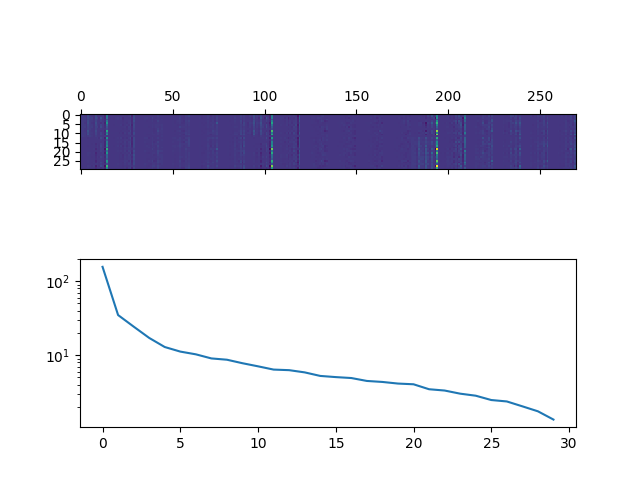

Time passed: 1065.561588 s
Iterations: 134
Number of Atoms: 30
Minimal pair-distance: 0.000220
Singular-Value norm: 269.495266
Full Matrix norm: 185.358436
Block matrix norm: 36.176021
LJ-Cost: 0.000000


<IPython.core.display.Javascript object>


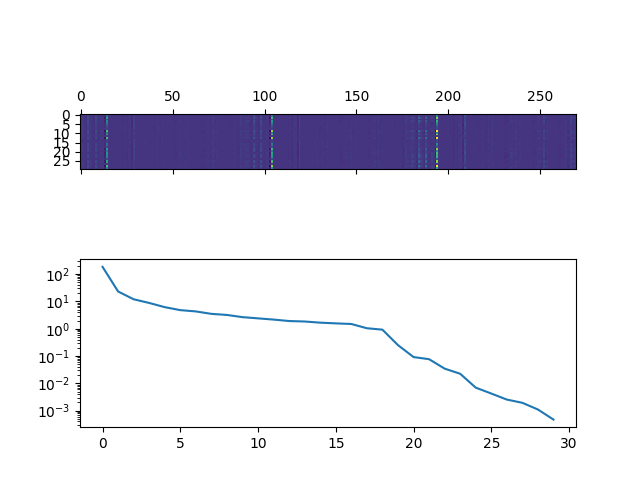

(185.3584363196806, 0)

In [8]:
seed = 50
sigma = 2
eps = 1
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test, seed=seed)
atoms_test = su.lim_overlap(atoms_test, sigma)
norm_LJ_opt(struct=atoms_test, eps=eps, sigma=sigma, maximization=False, pbc=True, full_output=True)

In [9]:
# time results: (pbc)
# 33 atoms: 27min
# 13 atoms: 911s
# 16 atoms: 919s
# 30 atoms: 1065s